```
By: Vinícius da S. Gomes
Student of Information Systems - UFRPE 
```



# **PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.


In [4]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import xgboost           as xgb
import missingno         as msno

from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('/content/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [6]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head(3)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


In [7]:
color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [8]:
df = df.iloc[:70000, :]

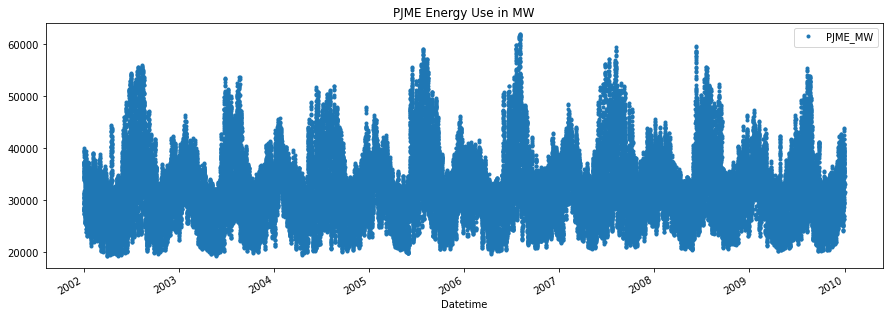

In [9]:
df.plot(style='.', figsize=(15, 5), color = color[0], title='PJME Energy Use in MW')
plt.show()

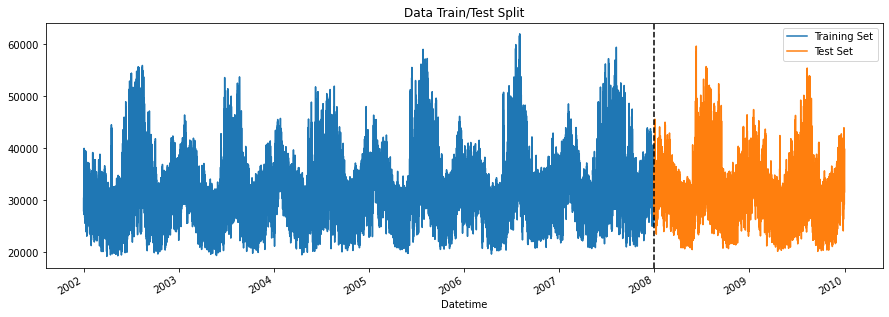

In [10]:
from matplotlib.rcsetup import ls_mapper
train = df.loc[df.index < '01-01-2008']
test = df.loc[df.index >= '01-01-2008']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2008', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

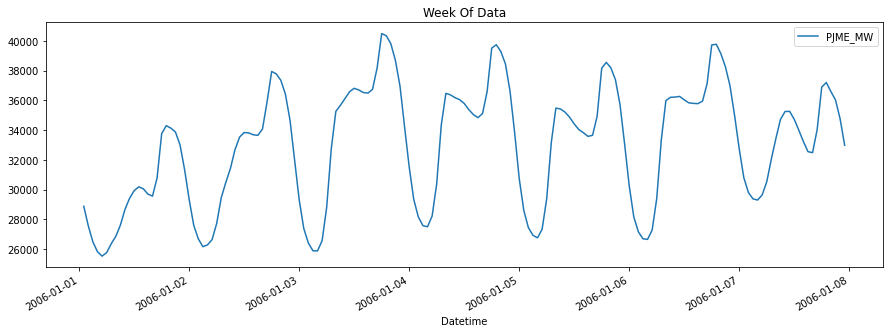

In [11]:
df.loc[(df.index > '01-01-2006') & (df.index < '01-08-2006')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [12]:
df.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            23,  0,  1,  2,  3,  4,  5,  6,  7,  8],
           dtype='int64', name='Datetime', length=70000)

In [13]:
def CreateFeatures(df):
  
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = CreateFeatures(df)

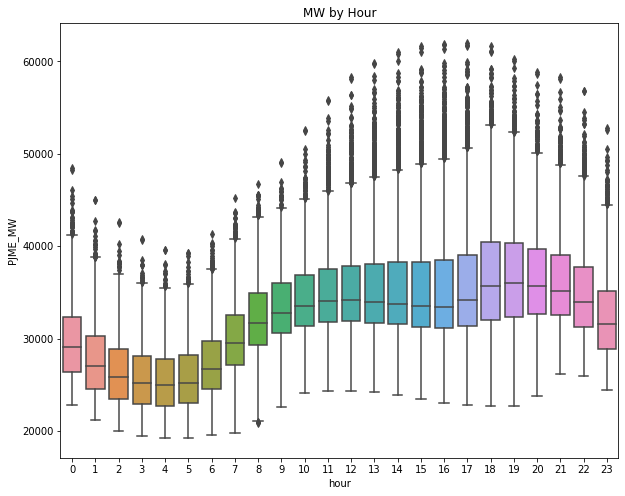

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

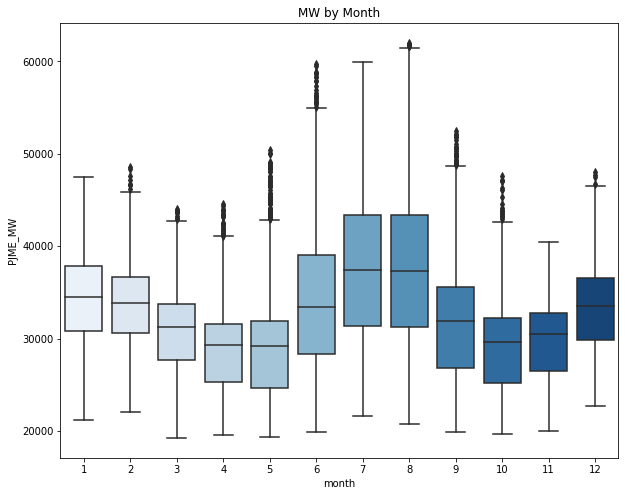

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [16]:
train = CreateFeatures(train)
test = CreateFeatures(test)


FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[15:09:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32797.2	validation_1-rmse:32628
[100]	validation_0-rmse:12640.8	validation_1-rmse:12411.6
[200]	validation_0-rmse:5820.93	validation_1-rmse:5495.91
[300]	validation_0-rmse:3853.31	validation_1-rmse:3540.25
[400]	validation_0-rmse:3336.18	validation_1-rmse:3207.22
[500]	validation_0-rmse:3152.68	validation_1-rmse:3201.62
[600]	validation_0-rmse:3058.78	validation_1-rmse:3224.14
[700]	validation_0-rmse:2999.48	validation_1-rmse:3240.2
[800]	validation_0-rmse:2955.07	validation_1-rmse:3251.5
[900]	validation_0-rmse:2916.76	validation_1-rmse:3263.46
[999]	validation_0-rmse:2885.26	validation_1-rmse:3275.19


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

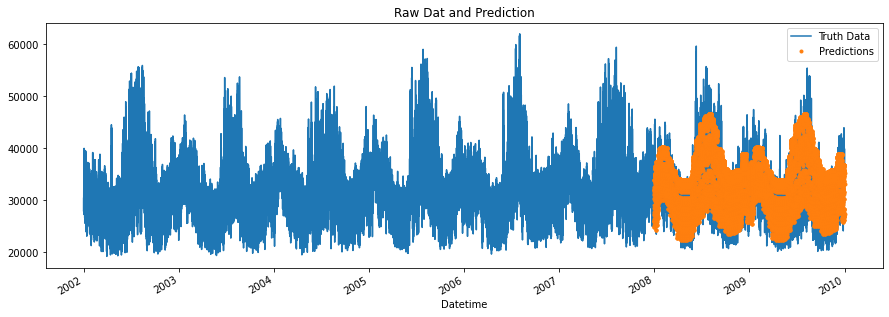

In [18]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

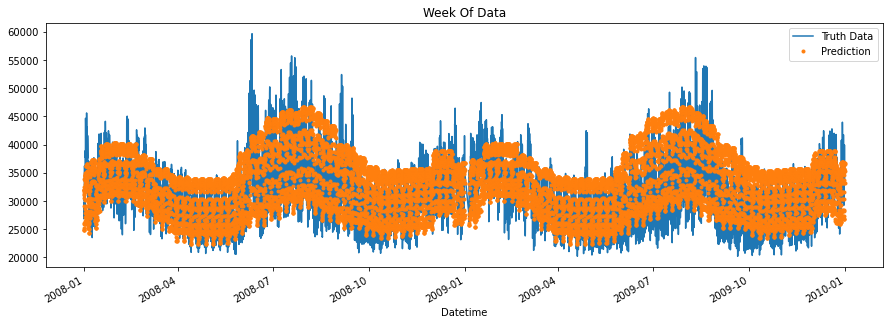

In [19]:
ax = df.loc[(df.index > '01-01-2008') & (df.index < '01-01-2010')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2008') & (df.index < '01-01-2010')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

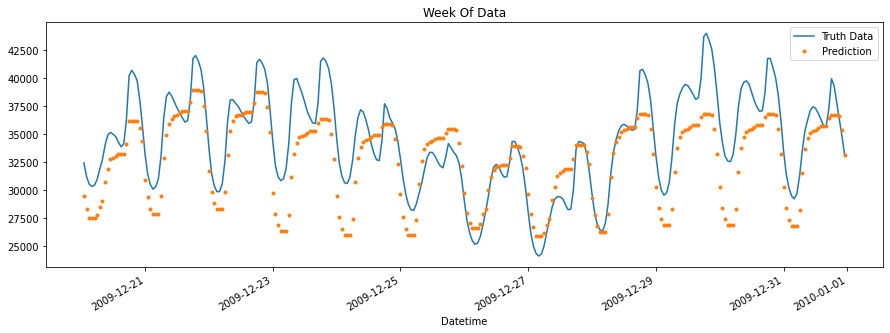

In [20]:
ax = df.loc[(df.index > '12-20-2009') & (df.index < '01-01-2010')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '12-20-2009') & (df.index < '01-01-2010')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [21]:
# Score (RMSE)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3275.19


In [22]:
# Calcule Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2008-06-09    11442.987223
2008-06-10    11316.576009
2008-06-08     9487.876302
2009-01-16     8477.314779
2008-12-22     8008.121257
2009-01-01     7727.427734
2008-07-20     7528.716227
2009-07-03     7481.616048
2008-01-03     7344.086019
2008-08-11     7281.714762
Name: error, dtype: float64